<font size="5">**Finding the Influence of Maximum Heart Rate and ST Depression on Heart Disease**</font>
<font size="3">*Prepared by Group 34: Felix Chan, Danielle De Martin, Avneet Kaur, Maggie Wang*</font>

<font size="3">**Introduction**</font>

The topic that we will be investigating is heart disease. The term “heart disease” refers to several types of heart conditions that affect the structure and the function of the heart, each with different root causes. Our analysis will not discriminate between the different types of heart disease, instead we will focus on the presence of heart diseases in general in correlation to attributes including maximum heart rate and ST depression.

The question we will be trying to answer is: Given an individual’s maximum heart rate and ST depression, do they have heart disease?
The dataset we will be using is from 1988 and contains 76 attributes in databases from patients in Cleveland, Hungary, Switzerland, and Long Beach V. However, all published experiments only use 14 of the attributes. To answer our question, we will be using 4 attributes to predict the presence of heart disease: age, cholesterol levels, and blood pressure. A person’s serum cholesterol (mg/dl) refers to the total amount of cholesterol in their blood. People diagnosed with heart disease (1) have >50% diameter narrowing in any of their major blood vessels, while people not diagnosed with heart disease (0) have <50% diameter narrowing in any of their major blood vessels. Blood pressure is measured as resting blood pressure (mm Hg).

<font size="3">**Method**</font>

<font size="3">**Results**</font>

In [2]:
# Loading all the required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Reading dataframe from the internet and storing it to a variable
heart_disease <- read_csv("https://raw.githubusercontent.com/maggie63/dsci-100-group-34/main/data/heart.csv") |>
    mutate(target = as_factor(target)) |>
    select(target, thalach, oldpeak)

# Printing the first few rows of the dataframe
head(heart_disease)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


target,thalach,oldpeak
<fct>,<dbl>,<dbl>
0,168,1.0
0,155,3.1
0,125,2.6
0,161,0.0
0,106,1.9
1,122,1.0


In [4]:
# Setting the seed
set.seed(1234)

# Splitting the data (75/25 training/testing split)
heart_split <- initial_split(heart_disease, prop = 0.75, strata = target)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

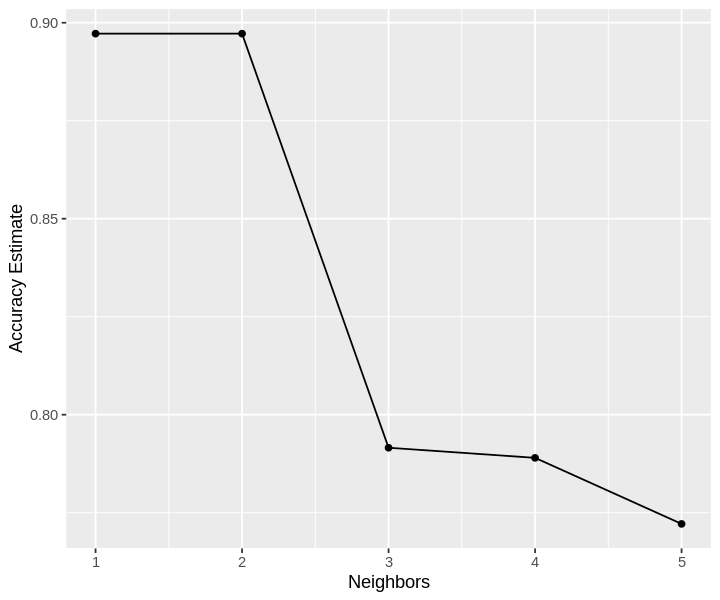

In [7]:
# Setting up
set.seed(567) 
options(repr.plot.height = 5, repr.plot.width = 6)

# Creating a model specification with tuning on the number of neighbours
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

# Recipe uses thalach and oldpeak to predict target - no heart disease (0), heart disease (1)
recipe <- recipe(target ~ thalach + oldpeak, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Testing k values from 1 to 10
k_vals <- tibble(neighbors = seq(1:5))

# Performing a 5-fold cross-validation on the training set
vfold <- vfold_cv(heart_training, v = 5, strata = target)

# Creating a workflow analysis with recipe and model specification and collecting metrics
knn_results <- workflow() |>
      add_recipe(recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = vfold, grid = k_vals) |>
      collect_metrics()

# Collecting the accuracies from the workflow analysis
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

# Plotting k vs accuracy
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

In [10]:
# Creating a final model using k = 2
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
        set_engine("kknn") |>
        set_mode("classification")
final_fit <- workflow() |>
      add_recipe(recipe) |>
      add_model(final_spec) |>
      fit(data = heart_training)

# Using model to predict on testing dataset
heart_predictions <- predict(final_fit , heart_testing) |>
      bind_cols(heart_testing)
head(heart_predictions)

# Accuracy of prediction
heart_metrics <- heart_predictions |>
        metrics(truth = target, estimate = .pred_class)
heart_metrics

#Creating a confusion matrix
heart_conf_mat <- heart_predictions |> 
      conf_mat(truth = target, estimate = .pred_class)
heart_conf_mat

.pred_class,target,thalach,oldpeak
<fct>,<fct>,<dbl>,<dbl>
0,0,168,1.0
0,0,106,1.9
0,0,145,0.8
0,0,144,0.8
0,0,116,3.2
0,0,122,4.2


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8871595
kap,binary,0.7755323


          Truth
Prediction   0   1
         0 125  29
         1   0 103

<font size="3">**Discussion**</font>

<font size="3">**References**</font>